# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

1. Download the Solar Sunspot Dataset

In [25]:
# Download dataset (monthly sunspot data)
filePath = 'sunspot_data.csv'
data = pd.read_csv(filePath)

In [26]:
# Display the first few rows
data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [27]:
# Filter out rows with invalid sunspot data (e.g., where "Number of Sunspots" is -1)
filtered_data = data[data['Number of Sunspots'] >= 0]

# Use only the "Number of Sunspots" column for the RNN
sunspots = filtered_data['Number of Sunspots'].values

# Display first few rows to check the data
filtered_data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
7,7,1818,1,8,1818.021,65,10.2,1,1
12,12,1818,1,13,1818.034,37,7.7,1,1
16,16,1818,1,17,1818.045,77,11.1,1,1
17,17,1818,1,18,1818.048,98,12.6,1,1
18,18,1818,1,19,1818.051,105,13.0,1,1


In [28]:
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Filtered data shape: (70471, 9)
Sunspots shape: (70471,)


2. Plot the Dataset Using Matplotlib

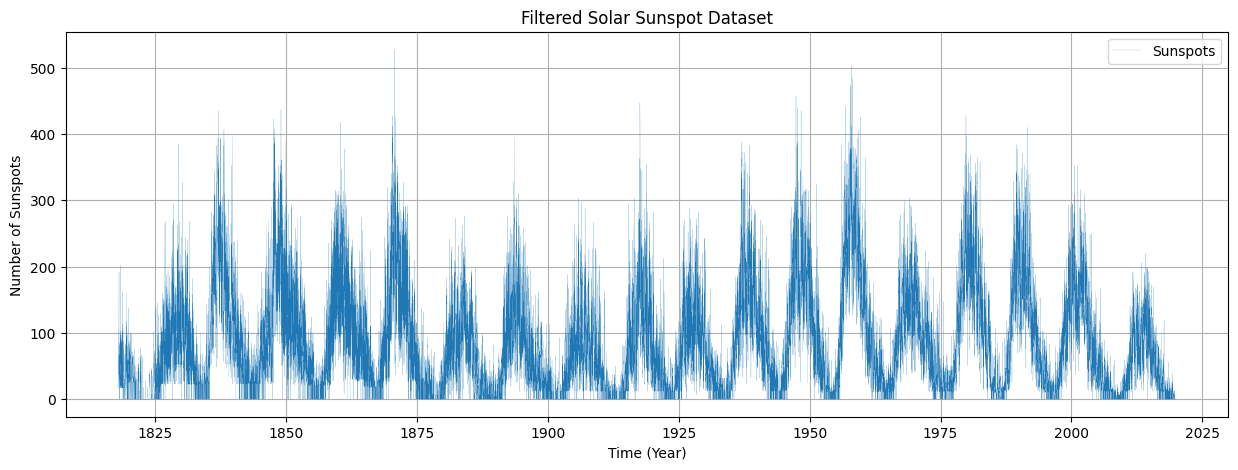

In [29]:
# Plot the dataset
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Date In Fraction Of Year'], sunspots, label='Sunspots', linewidth = 0.1)
plt.title('Filtered Solar Sunspot Dataset')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
len(filtered_data)

70471

In [31]:
filtered_data.shape

(70471, 9)

In [32]:
# Define window size (how many time steps to look back)
window_size = 12  # 12 months (or time steps)

hidden_size = 10
input_size = window_size  # Same as window_size

In [33]:
# Function to create a windowed dataset
def create_windowed_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [34]:
X, y = create_windowed_dataset(sunspots, window_size)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70459, 12), y shape: (70459,)


In [35]:
# Initialize weights and biases for LSTM gates
np.random.seed(42)
W_xh = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden
W_hh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden
W_f = np.random.randn(hidden_size, hidden_size + input_size) * 0.01  # Forget gate
W_i = np.random.randn(hidden_size, hidden_size + input_size) * 0.01  # Input gate
W_c = np.random.randn(hidden_size, hidden_size + input_size) * 0.01  # Candidate gate
W_o = np.random.randn(hidden_size, hidden_size + input_size) * 0.01  # Output gate
b_f = np.zeros((hidden_size, 1))
b_i = np.zeros((hidden_size, 1))
b_c = np.zeros((hidden_size, 1))
b_o = np.zeros((hidden_size, 1))

In [36]:
# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [37]:
def tanh(x):
    return np.tanh(x)

In [38]:
# Function to calculate MSE
def mean_squared_error(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

In [39]:
# LSTM cell
def LSTMCELL(prev_ct, prev_ht, input_t):
    # Concatenate previous hidden state and current input
    combine = np.concatenate((prev_ht, input_t), axis=0)

    # Forget gate
    ft = sigmoid(np.dot(W_f, combine) + b_f)

    # Candidate gate
    candidate = tanh(np.dot(W_c, combine) + b_c)

    # Input gate
    it = sigmoid(np.dot(W_i, combine) + b_i)

    # Update cell state
    Ct = prev_ct * ft + candidate * it

    # Output gate
    ot = sigmoid(np.dot(W_o, combine) + b_o)

    # Hidden state
    ht = ot * tanh(Ct)

    return ht, Ct

Training

In [40]:
# Training loop for LSTM
epochs = 10
learning_rate = 0.0001
errors = []

In [41]:
# Initial states
ct = np.zeros((hidden_size, 1))
ht = np.zeros((hidden_size, 1))

In [42]:
# Gradient clipping function
def clip_gradient(grad, threshold=1.0):
    return np.clip(grad, -threshold, threshold)

In [44]:
for epoch in range(epochs):
    total_loss = 0
    for i in range(X.shape[0]):
        # Reshape the input
        input_t = X[i].reshape(-1, 1)

        # Forward pass through the LSTM cell
        combine = np.concatenate((ht, input_t), axis=0)

        # Forget gate
        ft = sigmoid(np.dot(W_f, combine) + b_f)

        # Candidate gate
        candidate = tanh(np.dot(W_c, combine) + b_c)

        # Input gate
        it = sigmoid(np.dot(W_i, combine) + b_i)

        # Update cell state
        prev_ct = ct
        ct = prev_ct * ft + candidate * it

        # Output gate
        ot = sigmoid(np.dot(W_o, combine) + b_o)

        # Hidden state
        prev_ht = ht
        ht = ot * tanh(ct)

        # Output is the current hidden state (ht)
        y_pred = ht[-1, 0]  # Extracting the last value from hidden state as prediction

        # Compute the loss (MSE)
        loss = mean_squared_error(y_pred, y[i])
        total_loss += loss

        # Backpropagation
        dL_dy = 2 * (y_pred - y[i])  # Derivative of the loss function

        # Backpropagation through the output gate
        d_ot = dL_dy * tanh(ct)
        d_W_o = np.dot(d_ot, np.concatenate((prev_ht, input_t), axis=0).T)
        d_b_o = d_ot

        # Backpropagation through the cell state
        d_ct = dL_dy * ot * (1 - tanh(ct) ** 2)
        d_ft = d_ct * prev_ct
        d_W_f = np.dot(d_ft, np.concatenate((prev_ht, input_t), axis=0).T)
        d_b_f = d_ft

        # Backpropagation through the input gate
        d_it = d_ct * candidate
        d_W_i = np.dot(d_it, np.concatenate((prev_ht, input_t), axis=0).T)
        d_b_i = d_it

        # Backpropagation through the candidate gate
        d_candidate = d_ct * it * (1 - candidate ** 2)
        d_W_c = np.dot(d_candidate, np.concatenate((prev_ht, input_t), axis=0).T)
        d_b_c = d_candidate

        # Clip gradients to prevent exploding gradients
        d_W_f = clip_gradient(d_W_f)
        d_W_i = clip_gradient(d_W_i)
        d_W_c = clip_gradient(d_W_c)
        d_W_o = clip_gradient(d_W_o)
        d_b_f = clip_gradient(d_b_f)
        d_b_i = clip_gradient(d_b_i)
        d_b_c = clip_gradient(d_b_c)
        d_b_o = clip_gradient(d_b_o)

        # Update weights and biases
        W_f -= learning_rate * d_W_f
        W_i -= learning_rate * d_W_i
        W_c -= learning_rate * d_W_c
        W_o -= learning_rate * d_W_o
        b_f -= learning_rate * d_b_f
        b_i -= learning_rate * d_b_i
        b_c -= learning_rate * d_b_c
        b_o -= learning_rate * d_b_o

    # Average loss for the epoch
    avg_loss = total_loss / X.shape[0]
    errors.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')

/tmp/ipykernel_4536/486516741.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/10, Loss: 12684.728103815827
Epoch 2/10, Loss: 12684.732019742996
Epoch 3/10, Loss: 12684.801126467448
Epoch 4/10, Loss: 12684.815536255435
Epoch 5/10, Loss: 12684.811006211536
Epoch 6/10, Loss: 12684.782681206852
Epoch 7/10, Loss: 12684.716625065388
Epoch 8/10, Loss: 12684.788642096066
Epoch 9/10, Loss: 12684.767462957298
Epoch 10/10, Loss: 12684.802669640712


NameError: name 'predictions' is not defined

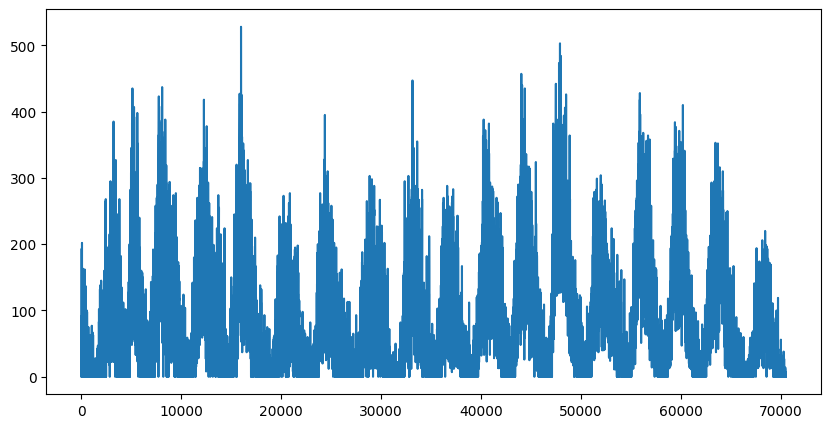

In [45]:
# Plot original data and predictions
plt.figure(figsize=(10, 5))
plt.plot(range(window_size, len(sunspots)), sunspots[window_size:], label='Original Data')
plt.plot(range(window_size, len(sunspots)), predictions, label='Predicted Data', linestyle='dashed')
plt.title('Sunspot Predictions vs Original Data')
plt.xlabel('Time (Index)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()